# ResNet MODEL 
#### Split train-test-validate: 65-25-10

##### Step 1. Import modules and load dataset

In [3]:
pip install tensorflow

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\DELL\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\tensorflow\\include\\external\\com_github_grpc_grpc\\src\\core\\ext\\filters\\client_channel\\lb_policy\\grpclb\\client_load_reporting_filter.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths




  Using cached tensorflow-2.16.1-cp311-cp311-win_amd64.whl.metadata (3.5 kB)
  Using cached tensorflow_intel-2.16.1-cp311-cp311-win_amd64.whl.metadata (5.0 kB)
Using cached tensorflow-2.16.1-cp311-cp311-win_amd64.whl (2.1 kB)
Using cached tensorflow_intel-2.16.1-cp311-cp311-win_amd64.whl (377.0 MB)


In [8]:
#Import required Libraries
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from pandas import read_csv
import multiprocessing as mp

import tensorflow
from tensorflow import keras
### Just to remove warnings to prettify the notebook. 
import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'tensorflow.python'

In [2]:
df = pd.read_csv('HPG Historical Data.csv',delimiter=";")
df

,Date,Price,Open,High,Low,Vol.,Change %
0,03/01/2024,30.850,31.200,31.200,30.650,26.96M,"-0,48%"
1,02/29/2024,31.000,30.750,31.150,30.500,33.58M,"1,31%"
2,02/28/2024,30.600,30.400,30.950,30.150,35.20M,"0,82%"
3,02/27/2024,30.350,28.900,30.450,28.800,86.84M,"5,38%"
4,02/26/2024,28.800,28.400,28.800,28.300,19.22M,"1,05%"
...,...,...,...,...,...,...,...
1247,03/07/2019,12.001,12.318,12.335,12.001,12.47M,"-2,57%"
1248,03/06/2019,12.318,12.318,12.388,12.107,9.24M,"-0,14%"
1249,03/05/2019,12.335,12.353,12.529,12.300,15.62M,"-0,85%"
1250,03/04/2019,12.441,12.230,12.441,12.212,13.74M,"3,21%"


In [3]:
# Convert the data types
df['Date'] = pd.to_datetime(df['Date'])

##### Step 2. Selecting attribute 

In [5]:
df = df[['Price']]
df = df.dropna() 
df = df.reset_index(drop=True) 
df

,Price
0,30.850
1,31.000
2,30.600
3,30.350
4,28.800
...,...
1247,12.001
1248,12.318
1249,12.335
1250,12.441


In [64]:
#ADF test
r = adfuller(train_data, autolag='AIC', regression='ct')
print('ADF Statistic: {}'.format(r[0]))
print('p-value: {}'.format(r[1]))
print('Critical Values:')
for key, value in r[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -0.8398183653877221
p-value: 0.962160288278823
Critical Values:
	1%: -3.969990247863827
	5%: -3.4159241045835755
	10%: -3.130248123197119


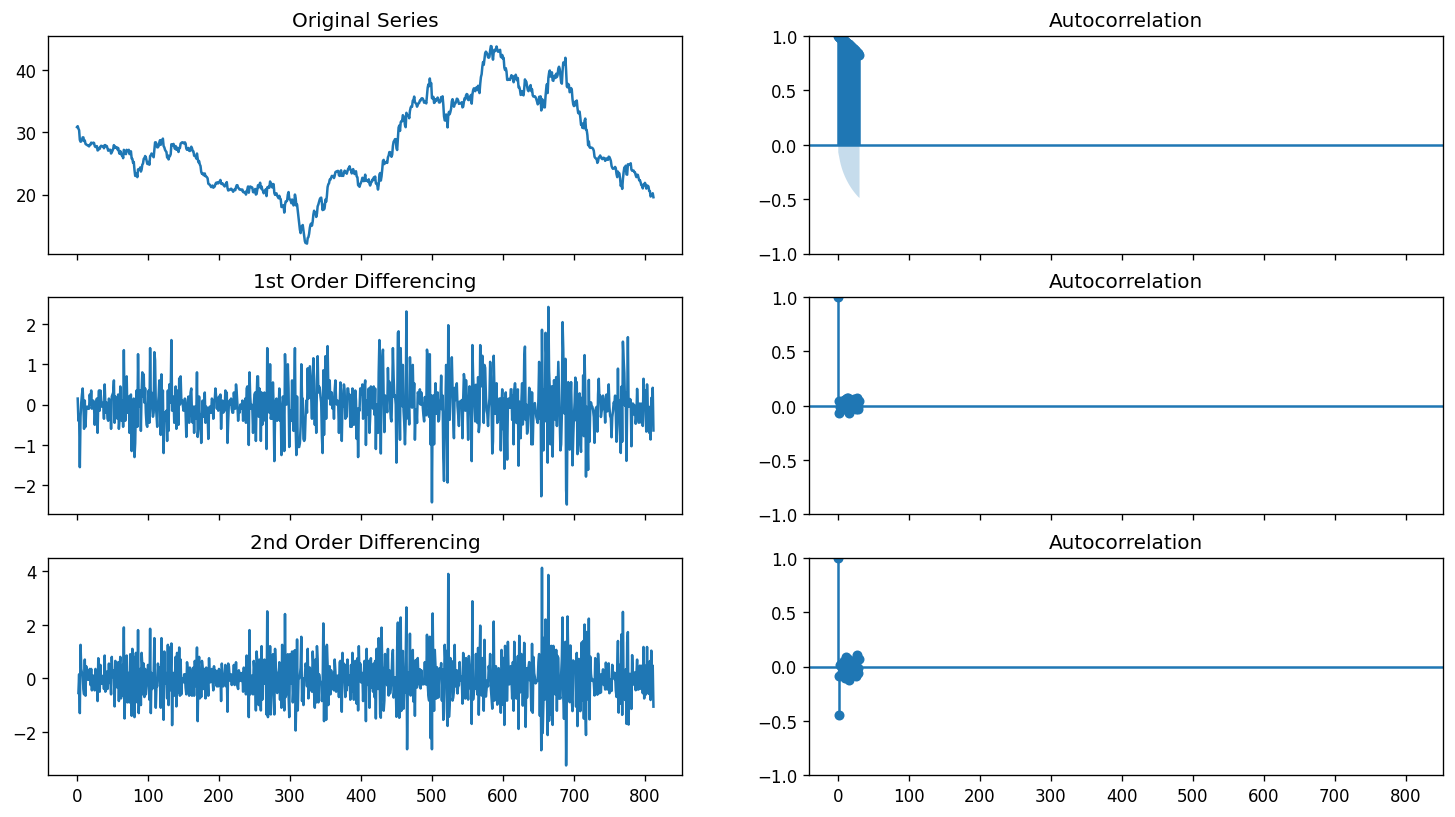

ADF Statistic for 1st Order Differencing
ADF Statistic: -21.077275
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569

 ADF Statistic for 2nd Order Differencing
ADF Statistic: -10.665448
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [65]:
plt.rcParams.update({'figure.figsize':(15,8), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(train_data); axes[0, 0].set_title('Original Series')
plot_acf(train_data, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(train_data.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(train_data.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(train_data.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train_data.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

print('ADF Statistic for 1st Order Differencing')
result = adfuller(train_data.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

print('\n ADF Statistic for 2nd Order Differencing')
result = adfuller(train_data.diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

##### Step 3. Split the dataset into train, test, validate

In [63]:
# Calculate the number of samples for each set
train_size = int(0.65 * len(df))
test_size = int(0.25 * len(df))
val_size = len(df) - train_size - test_size

# Split data into sets
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

# Check the size of each set
print("Train data size:", len(train_data))
print("Test data size:", len(test_data))
print("Validate data size:", len(val_data))

Train data size: 813
Test data size: 313
Validate data size: 126


##### Step 4. Process of training the model

In [7]:
!pip install pmdarima

In [53]:
# Process of Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train model
from pmdarima.arima import auto_arima
model = auto_arima(y_train, d=2, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=1.54 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2080.795, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1904.666, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1558.475, Time=0.19 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1558.238, Time=0.52 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=inf, Time=0.70 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=1557.073, Time=0.43 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=1558.782, Time=0.56 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=1559.368, Time=0.72 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=1559.009, Time=1.86 sec

Best model:  ARIMA(0,2,3)(0,0,0)[0]          
Total fit time: 7.290 seconds


ARIMA(order=(0, 2, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [54]:
# Process of Testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

In [55]:
# Process of Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

##### Step 5. Evaluate the accuracy of validation and test sets

In [59]:
# RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 4.800892627532468
Testing RMSE: 9.918117771490785


In [60]:
# MAPE
mape_test = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mape_validate = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
print('Validation MAPE:', mape_validate)
print('Testing MAPE:', mape_test)

Validation MAPE: 37.443594268211996
Testing MAPE: 71.99089572729463


In [62]:
# MAE
mae_test = np.mean(np.abs(y_test - y_pred))
mae_val = np.mean(np.abs(y_val - y_pred_val))
print("Validation MAE:", mae_val)
print("Testing MAE:", mae_test)

Validation MAE: 3.9443663473710266
Testing MAE: 7.533887602975755


##### Step 6. Forecasting 

##### a. The next 30 days

In [56]:
# Process of creating an index to predict the next 30 days
last_index = df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Creating an array for the next 30 days
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predicting the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Printing out the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[19.41691975 19.36380275 19.26875509 19.17370742 19.07865975 18.98361208
 18.88856441 18.79351675 18.69846908 18.60342141 18.50837374 18.41332608
 18.31827841 18.22323074 18.12818307 18.0331354  17.93808774 17.84304007
 17.7479924  17.65294473 17.55789707 17.4628494  17.36780173 17.27275406
 17.17770639 17.08265873 16.98761106 16.89256339 16.79751572 16.70246805]


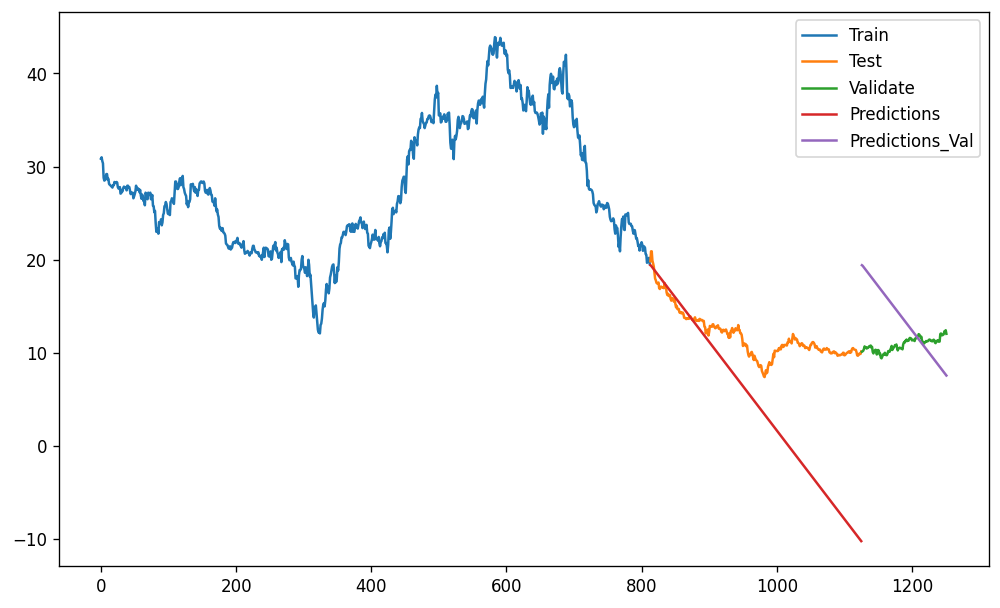

In [58]:
# Plot a graph
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index, val_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.legend(['Train', 'Test','Validate','Predictions','Predictions_Val'])
plt.show()

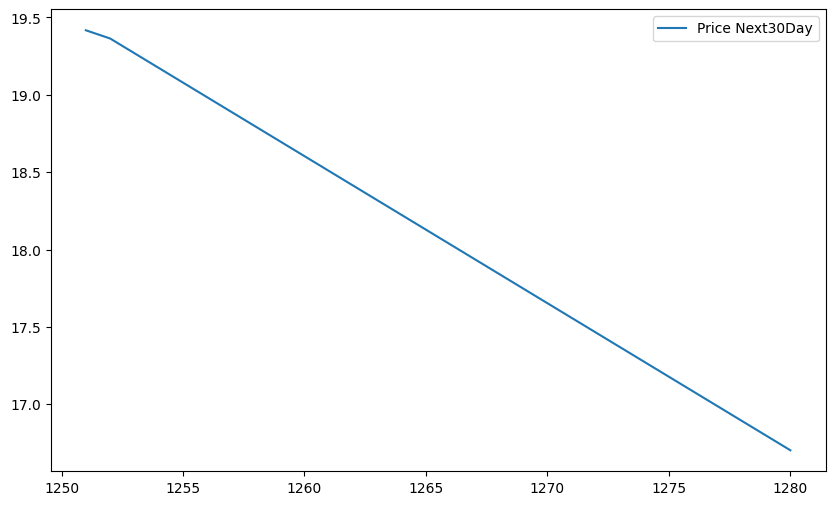

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(last_data,y_next_30_days)
plt.legend(['Price Next30Day'])
plt.show()

##### b. The next 60 days

In [32]:
# Process of creating an index to predict the next 60 days
last_index = df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+60, step=1)

# Creating an array for the next 60 days
x_next_60_days = np.array(range(last_index+1, last_index+61)).reshape(-1, 1)

# Predicting the next 60 days
y_next_60_days = model.predict(n_periods=len(x_next_60_days))

# Printing out the predicted closing prices for the next 60 days
print('Predicted closing prices for the next 60 days:')
print(y_next_60_days)

Predicted closing prices for the next 60 days:
[19.41691975 19.36380275 19.26875509 19.17370742 19.07865975 18.98361208
 18.88856441 18.79351675 18.69846908 18.60342141 18.50837374 18.41332608
 18.31827841 18.22323074 18.12818307 18.0331354  17.93808774 17.84304007
 17.7479924  17.65294473 17.55789707 17.4628494  17.36780173 17.27275406
 17.17770639 17.08265873 16.98761106 16.89256339 16.79751572 16.70246805
 16.60742039 16.51237272 16.41732505 16.32227738 16.22722972 16.13218205
 16.03713438 15.94208671 15.84703904 15.75199138 15.65694371 15.56189604
 15.46684837 15.37180071 15.27675304 15.18170537 15.0866577  14.99161003
 14.89656237 14.8015147  14.70646703 14.61141936 14.51637169 14.42132403
 14.32627636 14.23122869 14.13618102 14.04113336 13.94608569 13.85103802]


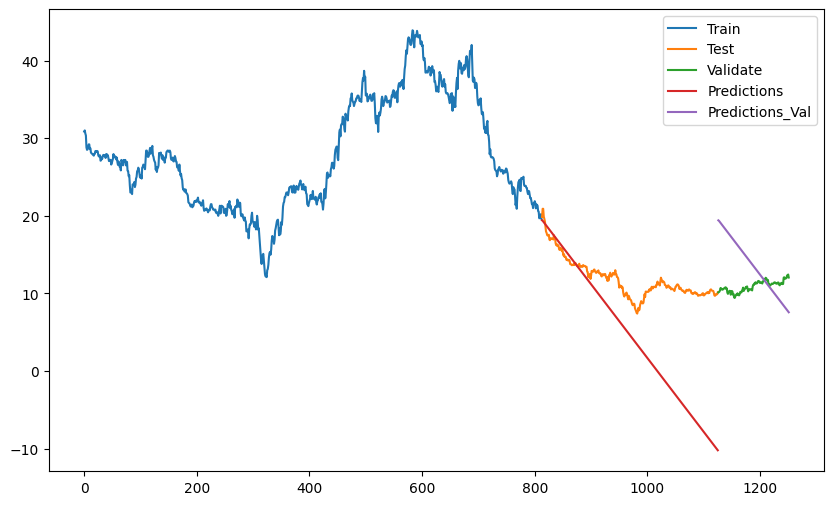

In [33]:
# Plot a graph
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index, val_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.legend(['Train', 'Test','Validate','Predictions','Predictions_Val'])
plt.show()

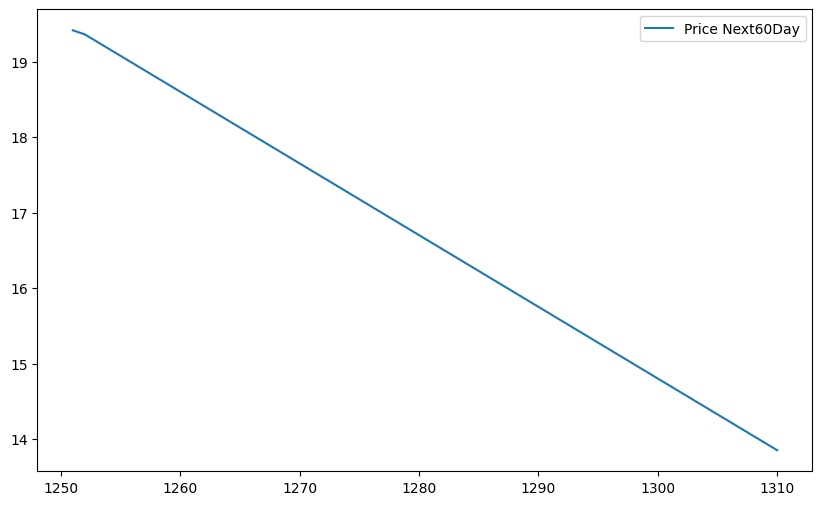

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(last_data,y_next_60_days)
plt.legend(['Price Next60Day'])
plt.show()

##### c. The next 90 days

In [35]:
# Process of creating an index to predict the next 90 days
last_index = df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)

# Creating an array for the next 90 days
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

# Predicting the next 90 days
y_next_90_days = model.predict(n_periods=len(x_next_90_days))

# Printing out the predicted closing prices for the next 90 days
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)

Predicted closing prices for the next 90 days:
[19.41691975 19.36380275 19.26875509 19.17370742 19.07865975 18.98361208
 18.88856441 18.79351675 18.69846908 18.60342141 18.50837374 18.41332608
 18.31827841 18.22323074 18.12818307 18.0331354  17.93808774 17.84304007
 17.7479924  17.65294473 17.55789707 17.4628494  17.36780173 17.27275406
 17.17770639 17.08265873 16.98761106 16.89256339 16.79751572 16.70246805
 16.60742039 16.51237272 16.41732505 16.32227738 16.22722972 16.13218205
 16.03713438 15.94208671 15.84703904 15.75199138 15.65694371 15.56189604
 15.46684837 15.37180071 15.27675304 15.18170537 15.0866577  14.99161003
 14.89656237 14.8015147  14.70646703 14.61141936 14.51637169 14.42132403
 14.32627636 14.23122869 14.13618102 14.04113336 13.94608569 13.85103802
 13.75599035 13.66094268 13.56589502 13.47084735 13.37579968 13.28075201
 13.18570435 13.09065668 12.99560901 12.90056134 12.80551367 12.71046601
 12.61541834 12.52037067 12.425323   12.33027534 12.23522767 12.14018
 12.045

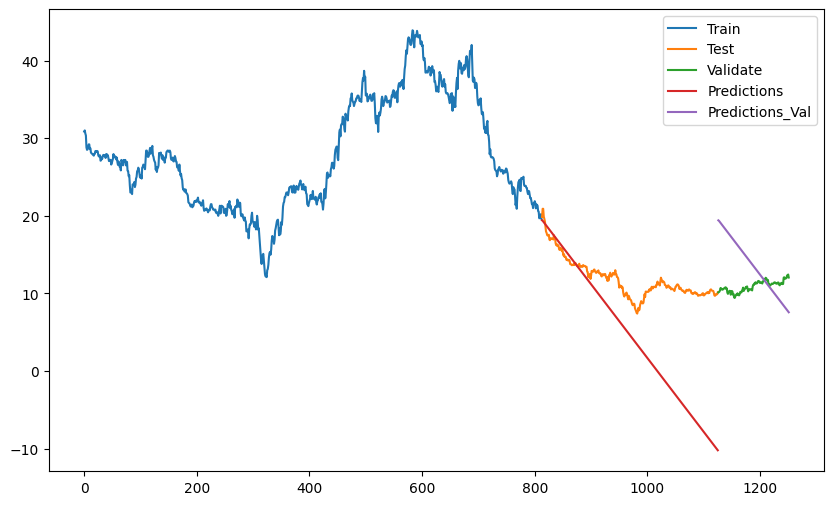

In [36]:
# Plot a graph
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index, val_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.legend(['Train', 'Test','Validate','Predictions','Predictions_Val'])
plt.show()

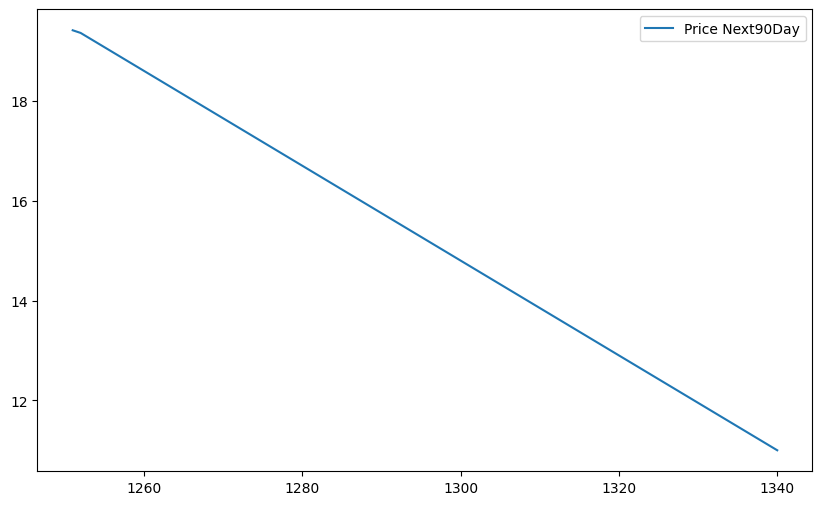

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(last_data,y_next_90_days)
plt.legend(['Price Next90Day'])
plt.show()